In [1]:
import ehrapy.api as ep
import pandas as pd

/home/thelichking/anaconda3/envs/scanpy_tutorial/lib/python3.9/site-packages/medcat/cat.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Model en_core_sci_sm is not installed. Refer to the ehrapy installation instructions if 
required.

Model en_core_sci_md is not installed. Refer to the ehrapy installation instructions if 
required.

In [2]:
ep.settings.n_jobs=8

In [3]:
# !wget https://medcat.rosalind.kcl.ac.uk/media/vocab.dat -P ./medcat_data/
# !wget https://medcat.rosalind.kcl.ac.uk/media/cdb-medmen-v1.dat -P ./medcat_data/
# !wget https://raw.githubusercontent.com/CogStack/MedCAT/master/tutorial/data/pt_notes.csv -P ./medcat_data/

In [4]:
medcat = ep.tl.MedCAT()

vocabulary = medcat.load_vocabulary("./medcat_data/vocab.dat")
concept_db = medcat.load_concept_db("./medcat_data/cdb-medmen-v1.dat")

concept_db.config.ner['min_name_len'] = 2
concept_db.config.ner['upper_case_limit_len'] = 3
concept_db.config.general['spell_check'] = True
concept_db.config.linking['train_count_threshold'] = 10
concept_db.config.linking['similarity_threshold'] = 0.3
concept_db.config.linking['train'] = True
concept_db.config.linking['disamb_length_limit'] = 5
concept_db.config.general['full_unlink'] = True

medcat.update_cat(vocabulary=vocabulary, concept_db=concept_db)

In [5]:
text = "He was diagnosed with kidney failure"
doc = medcat.cat(text)
doc.ents

(diagnosed, kidney failure)

In [6]:
medcat.cat.get_entities("He was diagnosed with kidney failure", only_cui=False)

{'entities': {0: {'pretty_name': 'Diagnosis Study',
   'cui': 'C1704656',
   'tuis': ['T062'],
   'types': ['Research Activity'],
   'source_value': 'diagnosed',
   'detected_name': 'diagnosed',
   'acc': 0.22160544957937056,
   'context_similarity': 0.22160544957937056,
   'start': 7,
   'end': 16,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 0,
   'meta_anns': {}},
  2: {'pretty_name': 'Kidney Failure',
   'cui': 'C0035078',
   'tuis': ['T047'],
   'types': ['Disease or Syndrome'],
   'source_value': 'kidney failure',
   'detected_name': 'kidney~failure',
   'acc': 1.0,
   'context_similarity': 1.0,
   'start': 22,
   'end': 36,
   'icd10': [],
   'ontologies': [],
   'snomed': [],
   'id': 2,
   'meta_anns': {}}},
 'tokens': []}

In [7]:
data = pd.read_csv("./medcat_data/pt_notes.csv")

In [8]:
data.head()

,Unnamed: 0_x,subject_id,chartdate,category,text,create_year,Unnamed: 0_y,gender,dob,dob_year,age_year
0,6,1,2079-01-01,General Medicine,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
1,7,1,2079-01-01,Rheumatology,"HISTORY OF PRESENT ILLNESS: , A 71-year-old fe...",2079,1,F,2018-01-01,2018,61
2,8,1,2079-01-01,Consult - History and Phy.,"HISTORY OF PRESENT ILLNESS:, The patient is a ...",2079,1,F,2018-01-01,2018,61
3,9,2,2037-01-01,Consult - History and Phy.,"CHIEF COMPLAINT:,1. Infection.,2. Pelvic pai...",2037,2,F,2018-01-01,2018,19
4,10,2,2037-01-01,Dermatology,"SUBJECTIVE:, This is a 29-year-old Vietnamese...",2037,2,F,2018-01-01,2018,19


In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data["text"][0])

HISTORY OF PRESENT ILLNESS:, The patient is a 71-year-old Caucasian female with a history of diabetes, osteoarthritis, atrial fibrillation, hypertension, asthma, obstructive sleep apnea on CPAP, diabetic foot ulcer, anemia and left lower extremity cellulitis. She was brought in by the EMS service to Erlanger emergency department with pulseless electrical activity. Her husband states that he was at home with his wife, when she presented to him complaining of fever and chills. She became acutely unresponsive. She was noted to have worsening of her breathing. She took several of her MDIs and then was placed on her CPAP. He went to notify EMS and when he returned, she was found to not be breathing. He stated that she was noted to have no breathing in excess of 10 minutes. He states that the EMS system arrived at the home and she was found not breathing. The patient was intubated at the scene and upon arrival to Erlanger Medical Center, she was found to have pupils fixed and dilated. She wa

In [10]:
adata = ep.io.read("../../medcat_data/pt_notes.csv", columns_obs_only=["subject_id", "chartdate", "text", "dob_year"], suppress_warnings=True)

In [11]:
medcat.cat.train(adata.obs.text.values, progress_print=100)

DONE: 0
DONE: 100
DONE: 200
DONE: 300
DONE: 400
DONE: 500
DONE: 600
DONE: 700
DONE: 800
DONE: 900
DONE: 1000


In [12]:
medcat.cat.cdb.print_stats()

Number of concepts: 34,724
Number of names:    92,740
Number of concepts that received training: 34,724
Number of seen training examples in total: 4,097,899
Average training examples per concept:     118.0


|T047|Disease or Syndrome    
|T048|Mental or Behavioral Dysfunction

In [13]:
filtered_cdb = medcat.filter_tui(medcat.concept_db, ['T047', 'T048'])

The size of the concept database is now: 1763

In [14]:
medcat.update_cat(vocabulary=vocabulary, concept_db=filtered_cdb)

In [16]:
annotation = medcat.annotate(adata.obs.text, batch_size=67, only_cui=True)

Output()

Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs
Annotated until now: 0 docs; Current BS: 68 docs


In [17]:
adata.obs["diagnoses"] = annotation.entities_pretty

In [18]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(adata.obs["diagnoses"][0])

{'Atrial Fibrillation', 'Asthma', 'Cardiac Arrest', 'Diabetic foot ulcer', 'Degenerative polyarthritis', 'Sleep Apnea, Obstructive', 'Anemia', 'Coronary Arteriosclerosis', 'Respiratory Failure', 'Mental disorders', 'Sepsis', 'Hypertensive disease', 'Diabetes Mellitus'}


In [19]:
subjects_diseases_pcts = medcat.calculate_disease_proportions(annotation.cui_locations,
                                                              adata.obs,
                                                              subject_id_col="subject_id")

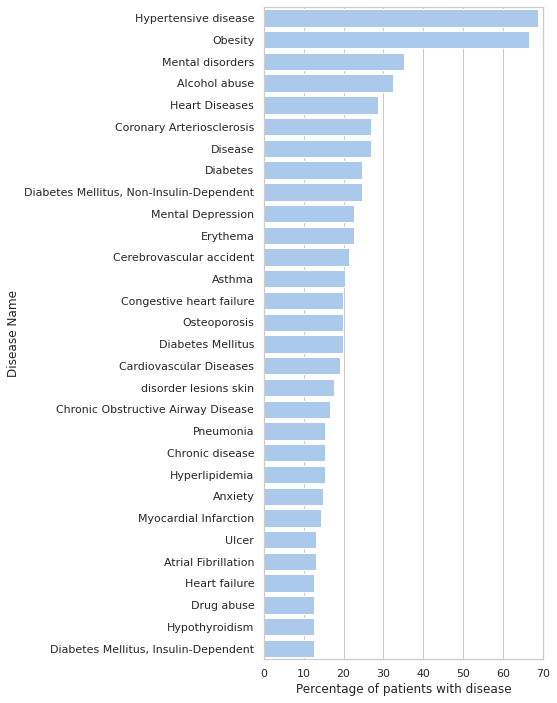

In [20]:
medcat.plot_top_diseases(subjects_diseases_pcts, 30)